In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Imports and read file to corpus

In [9]:
# If this code block complains, comment it out

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [25]:
import nltk
import gensim
import re
from gensim import corpora
from gensim.parsing.preprocessing import *
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import pyLDAvis.gensim
import numpy as np
import os
from pprint import pprint
# Figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

# For MAC OS
mallet_path = 'mallet-2.0.8/bin/mallet'
os.environ['MALLET_HOME'] = 'mallet-2.0.8'

# For Windows OS
#os.environ['MALLET_HOME'] = 'C:\\mallet'
#mallet_path = 'C:\\mallet\\bin\\mallet.bat'

In [7]:
def readFile(folder, filename):
    fileData = ""
    file = open(folder + "/" + filename, 'r', encoding='utf8')
    fileData = file.read().splitlines()
    file.close
    return fileData

In [8]:
def createEmptyFile(filename):
    file = open("authors/" + filename, 'w').close()

In [9]:
def saveToFile(filename, abstract):
    if len(abstract) > 0:
        file = open("authors/" + filename, 'a')
        try:
            file.writelines(abstract + "\n")
        except:
            file.write("\n")
            print("\n Write exception")
        file.close
        print('+', end='')
        return True
    else:
        print('-', end='')
        return False

# TODO
* change to (2000,2021)
* change to (2011,2021) for css
* append authors
* fix blankspace problem with authors in USENIX

In [10]:
corpus = []

# Used later to make diagrams
yearList = []
conferenceList = []
author = []

for i in range (2012,2021):
    conference = readFile('abstracts', 'usenix' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('Usenix')
        yearList.append(i)
    authors = readFile('authors', 'usenix' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
for i in range (2012,2021):
    conference = readFile('abstracts', 'css' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('CSS')
        yearList.append(i)
    authors = readFile('authors', 'css' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)     
for i in range (2000,2021):   
    conference = readFile('abstracts', 'ieee' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('IEEE')
        yearList.append(i)
    authors = readFile('authors', 'ieee' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)
for i in range (2012,2021):
    conference = readFile('abstracts', 'ndss' + str(i) + 'Abstracts.txt')
    for abstract in conference:
        corpus.append(abstract)
        conferenceList.append('NDSS')
        yearList.append(i)
    authors = readFile('authors', 'ndss' + str(i) + 'Authors.txt')
    for auth in authors:
        author.append(auth)

# Save the years and conferences in a Panda table
df_year_conf = pd.DataFrame(np.column_stack((yearList, conferenceList)), columns=['Year', 'Conf'])
df_authors = pd.DataFrame(author, columns=['Authors'])

#df_year_conf
   
#print(author)    
#print(corpus)
print(len(corpus))
print(len(author))

4175
4175


## Preprocessing of the corpus
Preprocess the raw corpues into a list of words for each document

In [11]:
df_authors

,Authors
0,"Damon McCoy, Andreas Pitsillidis and Grant Jo..."
1,"Gianluca Stringhini and Manuel Egele, Apostol..."
2,"Anirban Dasgupta, Kunal Punera, Justin M. R..."
3,"Y. Xu, G. Reynaga and S. Chiasson, J.-M. Fra..."
4,"Blase Ur, Patrick Gage Kelley, Saranga Komandu..."
...,...
4170,"Michael Schwarz , Moritz Lipp , Claudio Canell..."
4171,"Yang Zhang , Mathias Humbert , Bartlomiej Surm..."
4172,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar..."
4173,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita..."


In [12]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            # lemmatized_sentence.append(word)
            pass# This part is modified so that we will just have ADJ VERB NOUN ADVERB remained 
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [13]:
stop_words = ['achieve',
 'address',
 'analysis',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

def remove_ourStopwords(doc):
    return " ".join([word for word in doc.split() if word not in stop_words])

In [15]:
CUSTOM_FILTERS = [
    strip_tags,                            # Remove HTML tags and such
    strip_punctuation,                     # Remove punctuation
    strip_multiple_whitespaces,            # Remove unecessary space and such
    strip_numeric,                         # Remove numbers
    lambda x: strip_short(x, 4),           # Remove words shorter than 2 chars
    lambda y: y.replace('“', ''),          # Removes quation marks
    lambda z: z.replace('”', ''),          # Removes quation marks
    lambda a: a.lower(),                   # Makes the corpus lowercase
    lambda b: remove_stopwords(b),         # Removes stopwords 
    lambda c: remove_ourStopwords(c)       # Removes our stopwords
]

def clean_doc(doc):
    lematized_doc = lemmatize_sentence(doc)
    cleanDoc = preprocess_string(lematized_doc, CUSTOM_FILTERS)
    return cleanDoc

corpus_clean = [clean_doc(doc) for doc in corpus]


In [52]:
corpus_clean

[['online',
  'sale',
  'counterfeit',
  'unauthorized',
  'product',
  'drive',
  'robust',
  'underground',
  'advertising',
  'industry',
  'email',
  'spam',
  'black',
  'search',
  'engine',
  'optimization',
  'forum',
  'abuse',
  'virtually',
  'encounter',
  'enticement',
  'purchase',
  'drug',
  'prescription',
  'free',
  'online',
  'canadian',
  'pharmacy',
  'site',
  'clearly',
  'economically',
  'motivate',
  'shape',
  'underlie',
  'business',
  'enterprise',
  'understood',
  'precisely',
  'underground',
  'exploit',
  'rare',
  'opportunity',
  'view',
  'organizations—the',
  'glavmed',
  'spamit',
  'promotion',
  'pharmaceutical',
  'affiliate',
  'inside',
  'ground',
  'truth',
  'data',
  'year',
  'transaction',
  'cover',
  'sale',
  'depth',
  'empirical',
  'analysis',
  'worldwide',
  'consumer',
  'demand',
  'role',
  'independent',
  'party',
  'advertiser',
  'detailed',
  'cost',
  'accounting',
  'overall',
  'business',
  'model'],
 ['tradition

### Contiune the preprocessing, now with the list of words. Creating bigrams

In [16]:
bigram = gensim.models.Phrases(corpus_clean, min_count=5, threshold=50) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(corpus):
    return [bigram_mod[doc] for doc in corpus]

corpus_clean_bigram = make_bigrams(corpus_clean)

### Splitting the corpus and making it into a dictionary

In [17]:
dictionary = corpora.Dictionary(corpus_clean_bigram)
M1 = [dictionary.doc2bow(doc) for doc in corpus_clean_bigram]

### Making the tfidf model
Not in use for LDA Mallet

In [18]:
tfidf_model = gensim.models.TfidfModel(M1)
tfidf_M1 = tfidf_model[M1]
#print(tfidf_model)
#print(tfidf_M1)
#print(M1)

## Finding optimal number of topics
Machinelearingplus.com approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        print(num_topics)
        
    return model_list, coherence_values

### Coherence score over topics, Stepping every 4th
Stepping from 2 to 104 with a step length of 4

In [ ]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=104, start=2, step=4)

In [ ]:
coherence_values = [0.3250157403264292, 0.4116900808150424, 0.4277707176143622, 0.4419215919328382, 0.43300547700202796, 0.43331531510788773, 0.4507613241261437, 0.4401537362798364, 0.4436828004648704, 0.4321437701507225, 0.4287353256235635, 0.4345214971377863, 0.4207751964079457, 0.42903262376408574, 0.41356412264891634, 0.4094172711686478, 0.41385811506381215, 0.3971588021061537, 0.4020413137080951, 0.3944484660319797, 0.40475857425077855, 0.4043484985706639, 0.40233617235048474, 0.39983668071530726, 0.39050519443737175]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=102; start=2; step=4;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

In [98]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.325
Num Topics = 6  has Coherence Value of 0.4117
Num Topics = 10  has Coherence Value of 0.4278
Num Topics = 14  has Coherence Value of 0.4419
Num Topics = 18  has Coherence Value of 0.433
Num Topics = 22  has Coherence Value of 0.4333
Num Topics = 26  has Coherence Value of 0.4508
Num Topics = 30  has Coherence Value of 0.4402
Num Topics = 34  has Coherence Value of 0.4437
Num Topics = 38  has Coherence Value of 0.4321
Num Topics = 42  has Coherence Value of 0.4287
Num Topics = 46  has Coherence Value of 0.4345
Num Topics = 50  has Coherence Value of 0.4208
Num Topics = 54  has Coherence Value of 0.429
Num Topics = 58  has Coherence Value of 0.4136
Num Topics = 62  has Coherence Value of 0.4094
Num Topics = 66  has Coherence Value of 0.4139
Num Topics = 70  has Coherence Value of 0.3972
Num Topics = 74  has Coherence Value of 0.402
Num Topics = 78  has Coherence Value of 0.3944
Num Topics = 82  has Coherence Value of 0.4048
Num Topics = 86  ha

#### Result
This gives us the top highest coherence score:
- Num Topics = 26  has Coherence Value of 0.4508

### Coherence score over topics, Stepping every one
Now we want to be more exact but since the coherence is dropping with higher number of topics we reduce the upper limit.

Now we try to step from 2 to 70 on every value

In [68]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=M1, texts=corpus_clean_bigram, limit=30, start=10, step=1)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [69]:
coherence_values

[0.45741016711736143,
 0.43812237500413626,
 0.44700166760394505,
 0.4237243991755197,
 0.44138174061651375,
 0.47246420353643387,
 0.44475081862744803,
 0.4629257166589516,
 0.4586327146019771,
 0.4650390691639515,
 0.4507273100240664,
 0.46749012598310075,
 0.4522999250325796,
 0.44682130158115224,
 0.4681677957401466,
 0.43720424619327247,
 0.4646445062416126,
 0.4537427883096004,
 0.45912247985383015,
 0.441672999809767]

In [70]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4574
Num Topics = 3  has Coherence Value of 0.4381
Num Topics = 4  has Coherence Value of 0.447
Num Topics = 5  has Coherence Value of 0.4237
Num Topics = 6  has Coherence Value of 0.4414
Num Topics = 7  has Coherence Value of 0.4725
Num Topics = 8  has Coherence Value of 0.4448
Num Topics = 9  has Coherence Value of 0.4629
Num Topics = 10  has Coherence Value of 0.4586
Num Topics = 11  has Coherence Value of 0.465
Num Topics = 12  has Coherence Value of 0.4507
Num Topics = 13  has Coherence Value of 0.4675
Num Topics = 14  has Coherence Value of 0.4523
Num Topics = 15  has Coherence Value of 0.4468
Num Topics = 16  has Coherence Value of 0.4682
Num Topics = 17  has Coherence Value of 0.4372
Num Topics = 18  has Coherence Value of 0.4646
Num Topics = 19  has Coherence Value of 0.4537
Num Topics = 20  has Coherence Value of 0.4591
Num Topics = 21  has Coherence Value of 0.4417


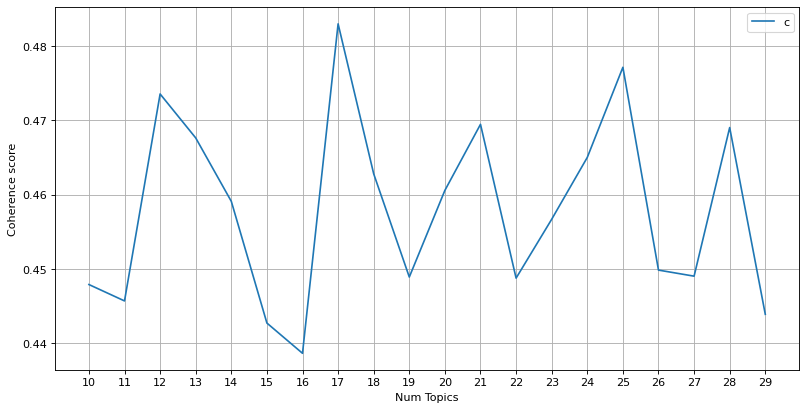

In [65]:
#coherence_values = [0.32571064083112744, 0.3537344947550003, 0.38589689375318126, 0.39384185450287246, 0.3968198253781281, 0.4085182731090585, 0.42127183913002364, 0.41899078263050016, 0.42801836357265693, 0.4309421068656622, 0.4235910756450276, 0.4516905876830981, 0.44230979084842603, 0.4296217041847969, 0.4312776000207533, 0.42955783914286844, 0.4300818857106711, 0.43599484572542013, 0.4288093062032049, 0.431145903679033, 0.45102550720523704, 0.4408525746026434, 0.43442023864813467, 0.437182271259546, 0.44709664105064434, 0.44248557145575135, 0.42246041004330903, 0.43784503147185494, 0.43667989244832234, 0.4351125576380536, 0.43902968092362493, 0.4440178347094399, 0.4271598549200618, 0.43617684419539876, 0.43125821112489443, 0.4329721336785587, 0.43217676681552086, 0.43310381516722185, 0.45072485690785824, 0.4401630451262257, 0.43130301356185136, 0.4334126436221655, 0.421009575540349, 0.4272964973804624, 0.4350421319148597, 0.4233540568965465, 0.4350122511003696, 0.43232603003979947, 0.41460403500831033, 0.42528017344333635, 0.4267933944574832, 0.4276083290805306, 0.4232434154417294, 0.4289482978832848, 0.4148342197092429, 0.4184389211956406, 0.4167830014416288, 0.41978178212929607, 0.40395936537564947, 0.40763329977423757, 0.421859133976826, 0.4079528877973058, 0.408300929971383, 0.41109076687251356, 0.4171141990155899, 0.40615382099134045, 0.4129390628617565, 0.40967900018905035]
coherence_values = [0.44791042556593086,
 0.44570386836410053,
 0.47357193355966426,
 0.46765378557318316,
 0.4591103114392938,
 0.44272426183711105,
 0.43865037957549907,
 0.48301381051033115,
 0.4628169743109464,
 0.4489204210874405,
 0.4605920384492901,
 0.46948401083986,
 0.4487734898353356,
 0.4567002420273789,
 0.46502981317091924,
 0.47716428768132146,
 0.44985512886666634,
 0.4490382019262274,
 0.46904895734035923,
 0.4439065928128975]
figure(figsize=(12, 6), dpi=80)
# Show graph
limit=30; start=10; step=1;
x = range(start, limit, step)
xi = list(x)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.xticks(xi, x)
plt.legend(("coherence_values"), loc='best')
plt.grid(True)
plt.show()

#### Result
This gives us:
- Num Topics = 13  has Coherence Value of 0.4517
- Num Topics = 21  has Coherence Value of 0.4311
- Num Topics = 40  has Coherence Value of 0.4507

And one can see that we now have three good candidates in the number of topics

## LDA mallet
Reads the LDA mallet model from the folder /mallet-2.0.8

In [48]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=M1,
                                             num_topics=5,
                                             id2word=dictionary)

In [49]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, 
                                           texts=corpus_clean_bigram,
                                           dictionary=dictionary, 
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('attack', 0.08722971724265385),
   ('user', 0.02939998767941847),
   ('data', 0.027428694634386745),
   ('device', 0.025611408858498122),
   ('access', 0.018434670116429495),
   ('attacker', 0.01597055381013984),
   ('server', 0.013706646953736216),
   ('channel', 0.012243577896876733),
   ('client', 0.011073122651389145),
   ('password', 0.01033388775950225)]),
 (1,
  [('code', 0.02665569380126095),
   ('application', 0.02478658706689728),
   ('vulnerability', 0.022289795235172685),
   ('program', 0.01689170339786866),
   ('software', 0.01514813368297718),
   ('exploit', 0.012888467332477822),
   ('memory', 0.01219103944652123),
   ('policy', 0.011744685599509011),
   ('hardware', 0.009652401941639235),
   ('flow', 0.009373430787256597)]),
 (2,
  [('privacy', 0.02705282791640353),
   ('user', 0.023880509333372497),
   ('data', 0.022558709923776236),
   ('model', 0.0218390635785516),
   ('information', 0.014378240244386024),
   ('malware', 0.011617148144340495),
   ('behavior'

## Setting upp the lda model
Used insted of LDA mallet

In [26]:
Lda = gensim.models.ldamodel.LdaModel
lda_model = Lda(tfidf_M1, 
                num_topics=2, 
                id2word = dictionary, 
                passes=18, 
                random_state =0)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Multicore

In [27]:
Lda = gensim.models.ldamulticore.LdaMulticore
lda_model = Lda(tfidf_M1 , 
                num_topics=8, 
                id2word = dictionary, 
                passes=15,
                random_state =0,
                workers=4)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=corpus_clean_bigram, 
                                     dictionary=dictionary)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6364102700593359


In [25]:
topics = lda_model.print_topics(num_topics=100, num_words=6)

for topic in topics:
    print(topic)

(0, '0.001*"abstract" + 0.001*"available" + 0.001*"flash" + 0.001*"rpki" + 0.001*"skimmer" + 0.001*"walkie_talkie"')
(1, '0.001*"helios" + 0.001*"prêt_voter" + 0.001*"volte" + 0.001*"coercion" + 0.001*"sanctum" + 0.001*"guis"')
(2, '0.002*"captchas" + 0.001*"rust" + 0.001*"captcha" + 0.001*"pill" + 0.001*"spurious" + 0.000*"macs"')
(3, '0.002*"workshop" + 0.001*"proverif" + 0.001*"quic" + 0.001*"meltdown" + 0.001*"protocol" + 0.001*"snarks"')
(4, '0.002*"rowhammer" + 0.001*"deduplication" + 0.001*"printer" + 0.001*"uninitialized" + 0.001*"spamming" + 0.001*"spammer"')
(5, '0.004*"attack" + 0.003*"user" + 0.003*"protocol" + 0.003*"data" + 0.003*"security" + 0.002*"network"')
(6, '0.001*"recommender" + 0.001*"bliss" + 0.001*"sdns" + 0.001*"journalist" + 0.000*"fake_visitations" + 0.000*"court"')
(7, '0.001*"vault" + 0.001*"crowdturfing" + 0.001*"fitness" + 0.001*"compartmentalization" + 0.001*"kerberos" + 0.001*"ethos"')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Visualisation of topics
First creating a lda mallet model and then visualising

In [50]:
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

In [51]:
print(dictionary)

Dictionary(16099 unique tokens: ['abuse', 'accounting', 'advertiser', 'advertising', 'affiliate']...)


In [52]:
lda_mallet_model = mallet_to_lda(ldamallet)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_mallet_model, M1, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.313207 -0.033848       1        1  20.304220
1      0.041964  0.169389       2        1  20.257011
0     -0.187921 -0.337856       3        1  20.028233
2      0.101485 -0.015201       4        1  19.804435
3     -0.268735  0.217517       5        1  19.606102, topic_info=            Term         Freq        Total Category  logprob  loglift
176       attack  6140.000000  6140.000000  Default  30.0000  30.0000
102     protocol  2165.000000  2165.000000  Default  29.0000  29.0000
172         user  3732.000000  3732.000000  Default  28.0000  28.0000
342      network  2148.000000  2148.000000  Default  27.0000  27.0000
13          data  3501.000000  3501.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
540  performance   447.887925   971.297711   Topic5  -5.0361   0.8552
33         model   520.462357  2040.740426   Topic5  -4.8859   0.2630
156    practical   355.614718   641.844187   Topic5  -5.2668   1.0388
135    framework   329.695278   818.835785   Topic5  -5.3425   0.7196
701    adversary   322.437835   743.108417   Topic5  -5.3647   0.7944

[369 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.998588          abuse
321       3  1.000161         access
1         1  1.021262     accounting
1096      4  0.999607       accuracy
1354      4  1.002361       accurate
...     ...       ...            ...
318       2  0.999928  vulnerability
1504      4  0.993887        warning
354       1  0.999661        website
1258      2  0.997747          write
65        1  0.998845           year

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 1, 3, 4])

In [38]:
stop_words = ['achieve',
 'address',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']
stop_words.sort()
stop_words

['achieve',
 'address',
 'analyze',
 'apply',
 'approach',
 'base',
 'based',
 'build',
 'change',
 'compare',
 'component',
 'conduct',
 'construct',
 'control',
 'demonstrate',
 'design',
 'develop',
 'effort',
 'enable',
 'evaluate',
 'exist',
 'high',
 'identify',
 'implement',
 'implementation',
 'include',
 'introduce',
 'large',
 'level',
 'mechanism',
 'method',
 'multiple',
 'number',
 'obtain',
 'paper',
 'perform',
 'potential',
 'practice',
 'present',
 'previous',
 'prior',
 'problem',
 'process',
 'propose',
 'provide',
 'purpouse',
 'recent',
 'reduce',
 'report',
 'require',
 'result',
 'security',
 'service',
 'single',
 'solution',
 'specifically',
 'state',
 'study',
 'support',
 'technique',
 'time',
 'tool',
 'work']

# Panda

In [53]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)


## Topic distribution over all documents

In [54]:
def topic_distribution(ldamodel, corpus, texts):
    topicPercent = []
    topicNumbers = []
    numberOfTopics = 0
    topicNames = []
    
    # Get all topics in each document
    for i, row in enumerate(ldamodel[corpus]):
        # Counts number of topics
        if i==0:
            numberOfTopics = len(row)
        topicPercent = []
        for topicNr, topicDistribution in row:
            topicPercent.append(topicDistribution)
        topicNumbers.append(topicPercent)

    dataframe = pd.DataFrame(topicNumbers)
    
    # Create names for each topic
    for i in range (0, numberOfTopics):
        topicName = 'Topic_' + str(i)
        topicNames.append(topicName)
        
    # Set all column lables
    dataframe.columns = topicNames
    
    return(dataframe)

topic_distribution_df = topic_distribution(ldamodel=lda_mallet_model, corpus=M1, texts=corpus_clean_bigram)
topic_distribution_df


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4
0,0.203903,0.191081,0.201120,0.194926,0.208970
1,0.186202,0.206010,0.202706,0.200305,0.204777
2,0.197477,0.207712,0.194086,0.183179,0.217547
3,0.201141,0.202112,0.198500,0.196980,0.201266
4,0.199566,0.192508,0.193823,0.216099,0.198004
...,...,...,...,...,...
4170,0.175556,0.220272,0.186860,0.205888,0.211425
4171,0.220151,0.195300,0.194747,0.183173,0.206629
4172,0.205279,0.188792,0.220645,0.186043,0.199241
4173,0.199888,0.191620,0.191922,0.196295,0.220275


## Topics per document
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.



In [33]:
lda_mallet_model.get_document_topics(M1[1],minimum_probability=0)

[(0, 0.06258033),
 (1, 0.0559719),
 (2, 0.05717837),
 (3, 0.05680286),
 (4, 0.059725054),
 (5, 0.062361922),
 (6, 0.059471924),
 (7, 0.059170313),
 (8, 0.058303554),
 (9, 0.056472544),
 (10, 0.06019121),
 (11, 0.056589153),
 (12, 0.05494866),
 (13, 0.05923321),
 (14, 0.056930866),
 (15, 0.059992995),
 (16, 0.064075164)]

In [34]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.0621,"model, algorithm, accuracy, learn, image, adve...","[online, sale, counterfeit, unauthorized, prod..."
1,1,16.0,0.0641,"application, vulnerability, android, code, flo...","[traditional, spam, detection, rely, content, ..."
2,2,2.0,0.0635,"attack, attacker, defense, exploit, target, vi...","[quantify, effect, unsolicited, email, spam, b..."
3,3,14.0,0.0642,"issue, test, impact, measure, case, public, le...","[explore, robustness, usability, moving, image..."
4,4,2.0,0.0772,"attack, attacker, defense, exploit, target, vi...","[help, user, create, strong, text, password, s..."
5,5,8.0,0.0633,"code, program, password, input, binary, genera...","[practical, algorithm, exploit, randomness, vu..."
6,6,13.0,0.0660,"policy, property, access, language, verify, ty...","[vulnerabilities, browser, extension, user, ri..."
7,7,2.0,0.0614,"attack, attacker, defense, exploit, target, vi...","[browser, mediate, access, valuable, private, ..."
8,8,14.0,0.0626,"issue, test, impact, measure, case, public, le...","[cryptographic, rely, secrecy, cryptographic, ..."
9,9,16.0,0.0652,"application, vulnerability, android, code, flo...","[brain, interface, increasingly, popular, gami..."


In [46]:
corpus[6]

'Vulnerabilities in browser extensions put users at risk by providing a way for website and network attackers to gain access to users’ private data and credentials. Extensions can also introduce vulnerabilities into the websites that they modify. In 2009, Google Chrome introduced a new extension platform with several features intended to prevent and mitigate extension vulnerabilities: strong isolation between websites and extensions, privilege separation within an extension, and an extension permission system. We performed a security review of 100 Chrome extensions and found 70 vulnerabilities across 40 extensions. Given these vulnerabilities, we evaluate how well each of the security mechanisms defends against extension vulnerabilities. We find that the mechanisms mostly succeed at preventing web attacks, but new security mechanisms are needed to protect users from network attacks on extensions, website metadata attacks on extensions, and vulnerabilities that extensions add to website

## Most representative document per topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [35]:
# Group top 5 corpuses under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0870,"scheme, server, client, performance, encryptio...","[censorship, research, largely, focus, highly,..."
1,1.0,0.0746,"memory, hardware, channel, software, performan...","[oblivious, random, access, machine, oram, all..."
2,2.0,0.0870,"attack, attacker, defense, exploit, target, vi...","[mobile, embed, apps, posse, sensitive, data, ..."
3,3.0,0.0753,"device, authentication, sensor, physical, sign...","[censorship_circumvention, proxy, resist, acti..."
4,4.0,0.0761,"protocol, secure, computation, party, proof, c...","[browser, extension, party, program, tightly, ..."
5,5.0,0.0728,"model, algorithm, accuracy, learn, image, adve...","[private, information_retrieval, client, query..."
6,6.0,0.0844,"malicious, detect, malware, detection, domain,...","[cyber, defense, evolve, physical, electronic,..."
7,7.0,0.0753,"framework, challenge, feature, software, evalu...","[market, share, statistic, mobile, device, tra..."
8,8.0,0.0763,"code, program, password, input, binary, genera...","[permission, access, user, manage, sensitive, ..."
9,9.0,0.0734,"network, traffic, internet, measurement, packe...","[emergence, voice, personal, assistant, ecosys..."


## Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
dominant_topic_list = topic_counts.rename_axis('Dominant_Topic').reset_index(name='Num_Topics')

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
dominant_topic_contribution = topic_contribution.rename_axis('Dominant_Topic').reset_index(name='Topics_Contribution')

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords.reset_index(level=0, inplace=True)
topic_num_keywords.columns = ['Document_ID', 'Dominant_Topic', 'Topic_Keywords']

# Concatenate Column wise
df_dominant_topics_contribution = pd.merge(dominant_topic_list, dominant_topic_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])
df_dominant_topics = pd.merge(topic_num_keywords, df_dominant_topics_contribution, how="inner", on=['Dominant_Topic', 'Dominant_Topic'])

# Sort by Document ID
df_dominant_topics = df_dominant_topics.sort_values(by=['Document_ID']).reset_index(drop=True).drop('Document_ID', axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Change to integer
df_dominant_topics['Dominant_Topic'] = df_dominant_topics['Dominant_Topic'].astype(np.int64)

# Add year and conference
df_document_per_topic = df_dominant_topics.join(df_year_conf)

# Show
df_document_per_topic

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Year,Conf
0,5,"model, algorithm, accuracy, learn, image, adve...",223,0.0534,2012,Usenix
1,16,"application, vulnerability, android, code, flo...",269,0.0644,2012,Usenix
2,2,"attack, attacker, defense, exploit, target, vi...",299,0.0716,2012,Usenix
3,14,"issue, test, impact, measure, case, public, le...",265,0.0635,2012,Usenix
4,2,"attack, attacker, defense, exploit, target, vi...",299,0.0716,2012,Usenix
...,...,...,...,...,...,...
4170,12,"research, participant, community, understand, ...",255,0.0611,2020,NDSS
4171,13,"policy, property, access, language, verify, ty...",509,0.1219,2020,NDSS
4172,13,"policy, property, access, language, verify, ty...",509,0.1219,2020,NDSS
4173,13,"policy, property, access, language, verify, ty...",509,0.1219,2020,NDSS


### Now we want to group all documents from a specific year
Hur många artiklar från Usenix 2012 har topic x?

paper - author - year - Conference - topic1 - topic 2 - ... - topic N 


In [47]:
df = df_year_conf.join(df_authors).join(topic_distribution_df)
df

,Year,Conf,Authors,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
0,2012,Usenix,"Damon McCoy, Andreas Pitsillidis and Grant Jo...",0.057614,0.062010,0.054571,0.057536,0.060468,0.062154,0.056662,0.058148,0.055824,0.059305,0.058001,0.059048,0.060406,0.061033,0.057427,0.058368,0.061424
1,2012,Usenix,"Gianluca Stringhini and Manuel Egele, Apostol...",0.062595,0.055986,0.057222,0.056827,0.059715,0.062320,0.059474,0.059128,0.058300,0.056475,0.060209,0.056554,0.054948,0.059222,0.056904,0.060014,0.064107
2,2012,Usenix,"Anirban Dasgupta, Kunal Punera, Justin M. R...",0.058270,0.059097,0.063460,0.057474,0.059186,0.056993,0.061049,0.061138,0.057173,0.057022,0.055960,0.055540,0.062548,0.059561,0.063076,0.055034,0.057420
3,2012,Usenix,"Y. Xu, G. Reynaga and S. Chiasson, J.-M. Fra...",0.055160,0.061426,0.057289,0.056799,0.056574,0.059292,0.061657,0.058132,0.055644,0.055565,0.060725,0.058641,0.060140,0.059312,0.064202,0.062206,0.057234
4,2012,Usenix,"Blase Ur, Patrick Gage Kelley, Saranga Komandu...",0.053206,0.057431,0.077207,0.060019,0.056667,0.063674,0.062411,0.056243,0.055684,0.056819,0.051173,0.056592,0.065618,0.056763,0.052788,0.059466,0.058239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4170,2020,NDSS,"Michael Schwarz , Moritz Lipp , Claudio Canell...",0.052786,0.062144,0.060833,0.051224,0.047735,0.067774,0.056793,0.069548,0.065862,0.060475,0.060907,0.053546,0.077507,0.047902,0.055641,0.056545,0.052780
4171,2020,NDSS,"Yang Zhang , Mathias Humbert , Bartlomiej Surm...",0.055473,0.061807,0.063782,0.057893,0.066367,0.062163,0.062641,0.059066,0.057900,0.052727,0.053583,0.057425,0.051206,0.069781,0.055287,0.057054,0.055844
4172,2020,NDSS,"Jairo Giraldo , Alvaro Cardenas , Murat Kantar...",0.062357,0.055527,0.060979,0.063185,0.055259,0.055089,0.056054,0.059427,0.058085,0.054407,0.055749,0.055967,0.058299,0.070110,0.063435,0.058709,0.057361
4173,2020,NDSS,"Tianhao Wang , Milan Lopuhaä-Zwakenberg , Zita...",0.058678,0.057389,0.060805,0.060389,0.061927,0.059218,0.055966,0.059946,0.056410,0.059257,0.057303,0.058663,0.057544,0.066379,0.056524,0.055596,0.058006


## Creating a plot function

In [38]:
def plotGraph(dataFrame):
    print(dataFrame.index[0])
    xMin = 1999 - int(dataFrame.index[0])
    xMax = 2021 - int(dataFrame.index[0])
    
    lables = []
    for num in range(1999, 2021):
        lables.append(str(num))
    
    dataFrame.plot(figsize=(20,10), ylim=(0.056,0.062), xlim=(xMin, xMax), xticks = range(xMin,xMax)).set_xticklabels(lables)

## Plotting topic distribution over years

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2000,0.058362,0.058738,0.058858,0.059212,0.058439,0.059044,0.059469,0.059181,0.058515,0.058242,0.058098,0.057946,0.058124,0.060268,0.059000,0.059313,0.059191
2001,0.059277,0.058894,0.058498,0.059446,0.059081,0.059146,0.059711,0.058479,0.059938,0.057263,0.057938,0.057712,0.058930,0.059264,0.058730,0.057540,0.060153
2002,0.058965,0.058001,0.058531,0.059628,0.059085,0.059365,0.058891,0.058575,0.058322,0.057635,0.058667,0.058310,0.059497,0.059392,0.059549,0.058445,0.059142
2003,0.059472,0.059217,0.058026,0.058825,0.058802,0.059408,0.060282,0.058152,0.058093,0.057877,0.058505,0.057106,0.058755,0.059831,0.059736,0.058492,0.059422
2004,0.059378,0.058014,0.058715,0.059671,0.058371,0.060422,0.059217,0.058205,0.058896,0.057582,0.057868,0.057419,0.059561,0.059795,0.059429,0.057878,0.059581
2005,0.058178,0.060668,0.059912,0.058707,0.058125,0.058666,0.059187,0.057160,0.059889,0.056993,0.058998,0.057639,0.060396,0.059702,0.059258,0.057593,0.058930
2006,0.058431,0.059142,0.058855,0.059134,0.058847,0.059153,0.058885,0.059562,0.058421,0.057238,0.058813,0.058381,0.059084,0.058837,0.059139,0.058323,0.059754
2007,0.058068,0.059244,0.058154,0.059259,0.058576,0.059237,0.059553,0.057944,0.059117,0.058252,0.058381,0.058779,0.058914,0.059169,0.059172,0.058297,0.059885
2008,0.059042,0.059204,0.059299,0.058886,0.058759,0.058466,0.059140,0.058301,0.058851,0.057287,0.059232,0.057531,0.058928,0.060559,0.059372,0.057933,0.059208


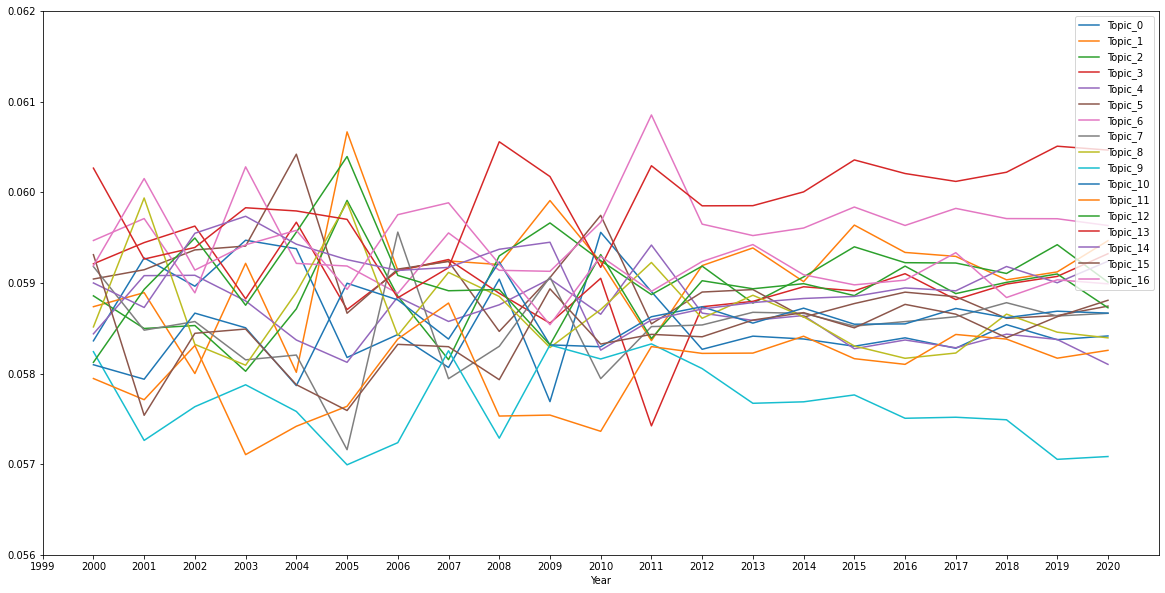

In [40]:
# Topic distribution over year graph
df_joined_year = df.groupby(['Year']).mean()
plotGraph(df_joined_year)
df_joined_year

2000


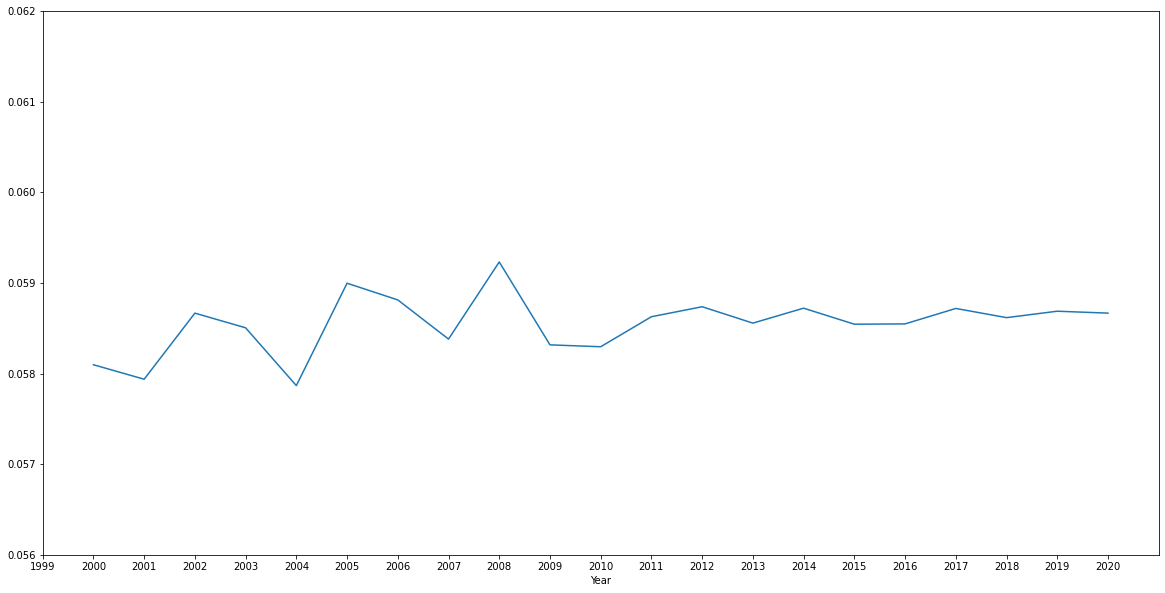

In [41]:
df_joined_year_topic10 = df_joined_year['Topic_10']
plotGraph(df_joined_year_topic10)

In [42]:
df_document_per_topic.sort_values('Perc_Documents')

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents,Year,Conf
2910,9,"network, traffic, internet, measurement, packe...",99,0.0237,2012,IEEE
497,9,"network, traffic, internet, measurement, packe...",99,0.0237,2016,Usenix
407,9,"network, traffic, internet, measurement, packe...",99,0.0237,2015,Usenix
1853,9,"network, traffic, internet, measurement, packe...",99,0.0237,2016,CSS
2756,9,"network, traffic, internet, measurement, packe...",99,0.0237,2007,IEEE
...,...,...,...,...,...,...
3584,13,"policy, property, access, language, verify, ty...",509,0.1219,2020,IEEE
2316,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS
2313,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS
2311,13,"policy, property, access, language, verify, ty...",509,0.1219,2019,CSS


### CSS graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.058369,0.058972,0.059123,0.058866,0.058783,0.058851,0.059943,0.058137,0.058592,0.057991,0.058776,0.058126,0.058742,0.060087,0.058656,0.058471,0.059517
2013,0.058361,0.059617,0.058605,0.058827,0.058553,0.059223,0.059404,0.058598,0.058906,0.057633,0.058563,0.057899,0.058850,0.060182,0.058699,0.058347,0.059733
2014,0.058405,0.059052,0.058773,0.058647,0.058800,0.058629,0.059635,0.058605,0.059092,0.057425,0.058559,0.058467,0.059219,0.059931,0.058687,0.058688,0.059384
2015,0.058530,0.059459,0.059481,0.058754,0.058099,0.058793,0.059915,0.058580,0.058482,0.057622,0.058383,0.058072,0.058691,0.060651,0.058920,0.058480,0.059087
2016,0.058191,0.059586,0.059757,0.058976,0.058359,0.059148,0.059664,0.058402,0.058059,0.057247,0.058416,0.058393,0.058847,0.060289,0.059003,0.058444,0.059220
2017,0.058375,0.059585,0.058982,0.058660,0.058379,0.058924,0.060201,0.058774,0.057988,0.057203,0.058767,0.058475,0.058660,0.060260,0.059058,0.058421,0.059288
2018,0.058528,0.059032,0.058979,0.058785,0.058566,0.058859,0.059750,0.058832,0.058835,0.057412,0.058545,0.058510,0.059070,0.060520,0.058984,0.058128,0.058665
2019,0.058581,0.059285,0.058980,0.059226,0.058243,0.058915,0.059454,0.058619,0.058648,0.057313,0.058515,0.058407,0.058763,0.060380,0.059263,0.058305,0.059101
2020,0.058080,0.059537,0.058864,0.059000,0.058075,0.059663,0.059350,0.059061,0.058829,0.057485,0.058690,0.058170,0.058130,0.060764,0.058993,0.058406,0.058900


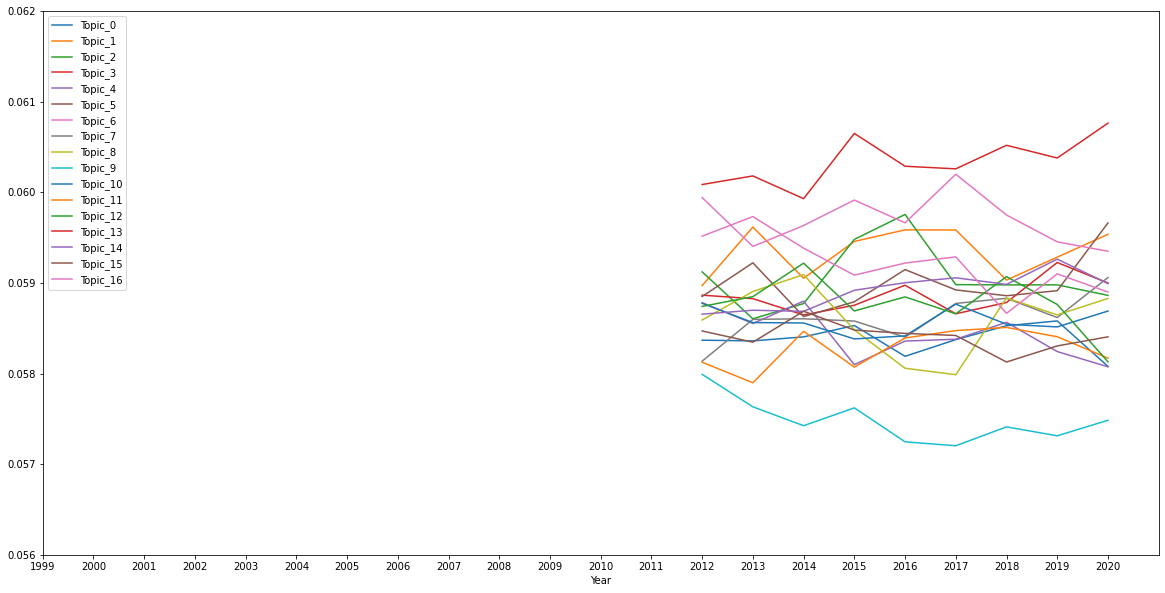

In [44]:
# Topic distribution over year graph for CSS
df_css = df[df['Conf'] == 'CSS'].groupby(['Year']).mean()
plotGraph(df_css)
df_css

### IEEE graph

2000


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2000,0.058362,0.058738,0.058858,0.059212,0.058439,0.059044,0.059469,0.059181,0.058515,0.058242,0.058098,0.057946,0.058124,0.060268,0.059000,0.059313,0.059191
2001,0.059277,0.058894,0.058498,0.059446,0.059081,0.059146,0.059711,0.058479,0.059938,0.057263,0.057938,0.057712,0.058930,0.059264,0.058730,0.057540,0.060153
2002,0.058965,0.058001,0.058531,0.059628,0.059085,0.059365,0.058891,0.058575,0.058322,0.057635,0.058667,0.058310,0.059497,0.059392,0.059549,0.058445,0.059142
2003,0.059472,0.059217,0.058026,0.058825,0.058802,0.059408,0.060282,0.058152,0.058093,0.057877,0.058505,0.057106,0.058755,0.059831,0.059736,0.058492,0.059422
2004,0.059378,0.058014,0.058715,0.059671,0.058371,0.060422,0.059217,0.058205,0.058896,0.057582,0.057868,0.057419,0.059561,0.059795,0.059429,0.057878,0.059581
2005,0.058178,0.060668,0.059912,0.058707,0.058125,0.058666,0.059187,0.057160,0.059889,0.056993,0.058998,0.057639,0.060396,0.059702,0.059258,0.057593,0.058930
2006,0.058431,0.059142,0.058855,0.059134,0.058847,0.059153,0.058885,0.059562,0.058421,0.057238,0.058813,0.058381,0.059084,0.058837,0.059139,0.058323,0.059754
2007,0.058068,0.059244,0.058154,0.059259,0.058576,0.059237,0.059553,0.057944,0.059117,0.058252,0.058381,0.058779,0.058914,0.059169,0.059172,0.058297,0.059885
2008,0.059042,0.059204,0.059299,0.058886,0.058759,0.058466,0.059140,0.058301,0.058851,0.057287,0.059232,0.057531,0.058928,0.060559,0.059372,0.057933,0.059208


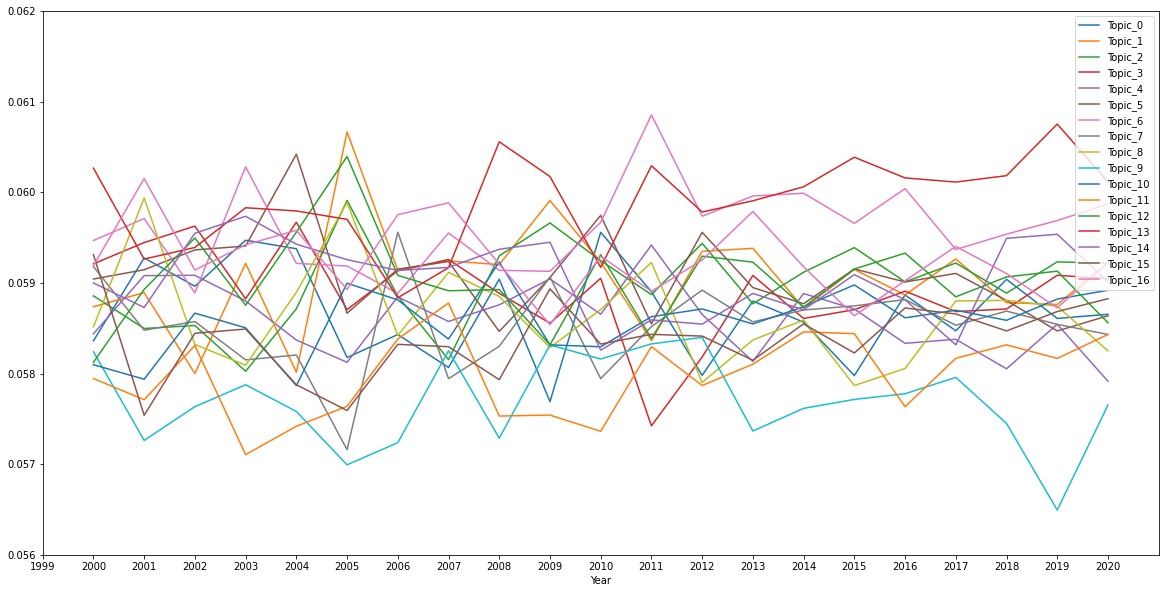

In [45]:
# Topic distribution over year graph for IEEE
df_ieee = df[df['Conf'] == 'IEEE'].groupby(['Year']).mean()
plotGraph(df_ieee)
df_ieee

### USENIX graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.059461,0.059086,0.058865,0.059161,0.058338,0.058893,0.059086,0.058771,0.058752,0.058247,0.058652,0.057783,0.059261,0.059915,0.058529,0.058525,0.058674
2013,0.059070,0.058815,0.058352,0.059276,0.058412,0.058551,0.059210,0.058697,0.059049,0.057945,0.058724,0.058098,0.059789,0.059750,0.058870,0.058435,0.058957
2014,0.059571,0.058955,0.058275,0.059253,0.058798,0.058777,0.059436,0.058436,0.058927,0.058306,0.058417,0.058266,0.059049,0.059652,0.058751,0.058663,0.058468
2015,0.059445,0.059162,0.057827,0.059112,0.058376,0.058389,0.059416,0.058650,0.060089,0.057861,0.058741,0.057717,0.059497,0.059201,0.058701,0.058768,0.059050
2016,0.059455,0.059643,0.057832,0.059124,0.058645,0.058387,0.059508,0.058367,0.059486,0.057844,0.058048,0.058040,0.059408,0.059494,0.058931,0.059200,0.058587
2017,0.059423,0.059122,0.058518,0.059375,0.058454,0.058800,0.059209,0.058833,0.059400,0.057515,0.057949,0.057860,0.059841,0.059889,0.058612,0.058769,0.058432
2018,0.059115,0.059305,0.058664,0.059212,0.058664,0.058966,0.059102,0.058332,0.059001,0.057857,0.058299,0.057961,0.059277,0.059719,0.058769,0.058967,0.058792
2019,0.059587,0.059250,0.058662,0.058977,0.058812,0.058181,0.059408,0.058336,0.059284,0.057348,0.058022,0.058100,0.059316,0.060276,0.058808,0.058894,0.058739
2020,0.059192,0.059016,0.058626,0.059192,0.058743,0.058782,0.058694,0.058433,0.059829,0.057700,0.058003,0.057661,0.059477,0.059806,0.058833,0.058991,0.059020


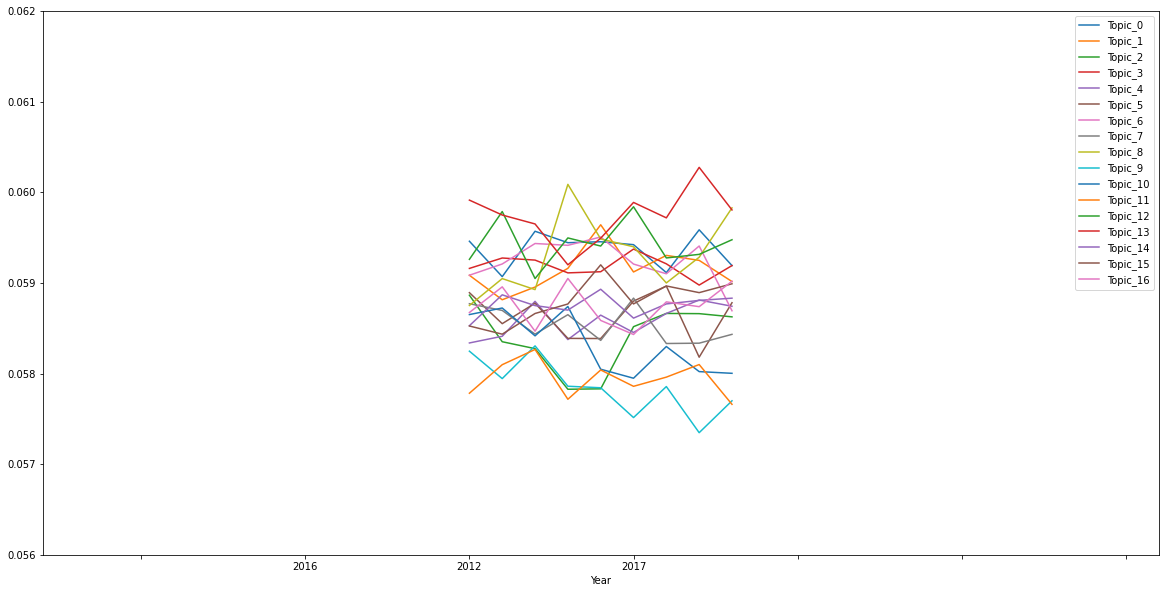

In [118]:
# Topic distribution over year graph for USENIX
df_usenix = df[df['Conf'] == 'Usenix'].groupby(['Year']).mean()
plotGraph(df_usenix)
df_usenix

### NDSS graph

2012


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
Year,,,,,,,,,,,,,,,,,
2012,0.058988,0.058910,0.058703,0.059077,0.058616,0.058735,0.058996,0.058560,0.059044,0.058400,0.058797,0.058717,0.058941,0.059141,0.058973,0.058610,0.058792
2013,0.059125,0.059286,0.058651,0.059037,0.058674,0.058587,0.058669,0.058519,0.058797,0.058495,0.058770,0.058474,0.059018,0.059362,0.058709,0.058704,0.059121
2014,0.059001,0.058933,0.058761,0.058881,0.058827,0.058807,0.058972,0.058705,0.059137,0.058459,0.058710,0.058830,0.058778,0.059171,0.058544,0.058860,0.058624
2015,0.059146,0.058496,0.058269,0.059005,0.059192,0.058357,0.060224,0.058636,0.059404,0.057253,0.058088,0.057858,0.059949,0.060107,0.059261,0.058873,0.057882
2016,0.058663,0.058802,0.058680,0.059426,0.060262,0.059426,0.058831,0.059405,0.058837,0.057823,0.057569,0.058538,0.061196,0.057370,0.058212,0.057710,0.059250
2017,0.059570,0.059078,0.058535,0.059355,0.058654,0.058251,0.059475,0.058544,0.059430,0.057681,0.057933,0.057668,0.059769,0.059253,0.058772,0.058699,0.059333
2019,0.058829,0.060031,0.058539,0.059414,0.059542,0.059440,0.058573,0.058298,0.059822,0.056580,0.057619,0.057363,0.060841,0.060945,0.058368,0.058101,0.057693
2020,0.058873,0.060305,0.059427,0.060627,0.057744,0.058666,0.058687,0.058738,0.060107,0.056177,0.056344,0.057300,0.060659,0.060764,0.058024,0.059177,0.058380


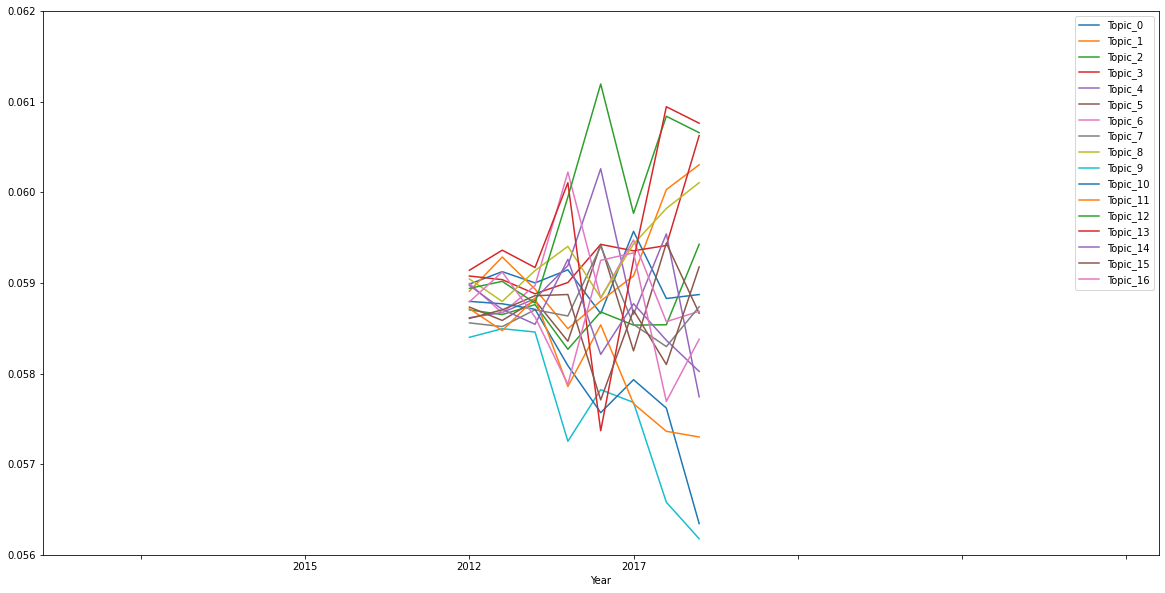

In [119]:
# Topic distribution over year graph for NDSS
df_ndss = df[df['Conf'] == 'NDSS'].groupby(['Year']).mean()
plotGraph(df_ndss)
df_ndss